In [1]:
from math import inf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure

In [2]:
def create_graph(file_path):
    g1 = nx.DiGraph() #Digraph containing only low crowded links
    g2 = nx.DiGraph() #Digraph containing low and medium crowded links
    g3 = nx.DiGraph() #Digraph containing all links
    
    with open(file_path) as network_file:
        for line in network_file.readlines()[5:]:
            tail, head, crowding, travel_time = line.split(',')
            tail = int(tail)
            head = int(head)
            crowding = int(crowding)
            travel_time = float(travel_time)
            
            #tt: travel time
            #cd: medium crowded duration in g2
            #cd1: high crowded duration
            #cd2: medium and high crowded duration
            #cd3: medium crowded duration in g3
            if crowding == 0:
                g1.add_edge(tail, head, tt=travel_time)
                g2.add_edge(tail, head, tt=travel_time, cd=0)
                g3.add_edge(tail, head, tt=travel_time, cd1=0, cd2=0, cd3=0)
            elif crowding == 1:
                g2.add_edge(tail, head, tt=travel_time, cd=travel_time)
                g3.add_edge(tail, head, tt=travel_time, cd1=0, cd2=travel_time, cd3=travel_time)
            else:
                g3.add_edge(tail, head, tt=travel_time, cd1=travel_time, cd2=travel_time, cd3=0)
    return g1, g2, g3

In [3]:
def get_od_from_user():
    #getting origin and destination from user
    origin = int(input("Enter origin:"))
    destination = int(input("Enter destination:"))
    
    return origin, destination

In [4]:
def get_shortest_tt(g1, g2, g3, origin, destination):
    #for finding optimal paths in terms of travel times and their corresponding crowded duration
    tt1 = tt2 = tt3 = cd_max = cd1_max = cd2_max = 0
    
    try:
        g1_shortest_path = next(nx.shortest_simple_paths(g1, origin, destination, weight="tt"))
        
        #for finding path level travel time
        for i in range(len(g1_shortest_path)-1):
            tt1 += g1[g1_shortest_path[i]][g1_shortest_path[i+1]]["tt"]
    
    except nx.NodeNotFound:
        print(origin, "or", destination, "not present in g1!")
        tt1 = -1
    
    except nx.NetworkXNoPath:
        print("No path between", origin, "and", destination, "in g1!")
        tt1 = -2
        
    try:
        g2_shortest_path = next(nx.shortest_simple_paths(g2, origin, destination, weight="tt"))
        
        for i in range(len(g2_shortest_path)-1):
            tt2 += g2[g2_shortest_path[i]][g2_shortest_path[i+1]]["tt"]
            cd_max += g2[g2_shortest_path[i]][g2_shortest_path[i+1]]["cd"]
            
    except nx.NodeNotFound:
        print(origin, "or", destination, 'not present in g2!')
        tt2 = -1
    
    except nx.NetworkXNoPath:
        print("No path between", origin, "and", destination, "in g2!")
        tt2 = -2
        
    try:
        g3_shortest_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="tt"))
        
        for i in range(len(g3_shortest_path)-1):
            tt3 += g3[g3_shortest_path[i]][g3_shortest_path[i+1]]["tt"]
            cd1_max += g3[g3_shortest_path[i]][g3_shortest_path[i+1]]["cd1"]
            cd2_max += g3[g3_shortest_path[i]][g3_shortest_path[i+1]]["cd2"]
        
    except nx.NodeNotFound:
        print(origin, "or", destination, "not present in g3")
        tt3 = -1
        
    except nx.NetworkXNoPath():
        print("No path between", origin, "and", destination, "in g3!")
        tt3 = -2

    return tt1, tt2, tt3, cd_max, cd1_max, cd2_max

In [5]:
def get_pareto_set(graph, optimal_tt, max_cd, origin, destination, indicator):
    pareto_set = []
    
    #indicator = 1 if graph is g2 and medium crowded duration is used
    #indicator = 2 if graph is g3 and high crowded duration is used
    #indicator = 3 if graph is g3 and at least medium crowded duration is used
    
    if indicator == 1:
        obj_fn = "cd"
    elif indicator == 2:
        obj_fn = "cd1"
    else:
        obj_fn = "cd2"
        
    shortest_cd_paths = nx.shortest_simple_paths(graph, origin, destination, weight=obj_fn)
    
    
    #to check if the next path obtained is dominated by the current path or not
    prev_path_tt = inf
    prev_path_cd = inf
    
    while True:
        try:
            path = next(shortest_cd_paths)
            path_tt = path_cd = path_cd1 = path_cd2 = 0
            
            for i in range(len(path) -1):
                path_tt += graph[path[i]][path[i+1]]["tt"]
                
                if indicator ==1:
                    path_cd += graph[path[i]][path[i+1]]["cd"]
                else:
                    path_cd1 += graph[path[i]][path[i+1]]["cd1"]
                    path_cd2 += graph[path[i]][path[i+1]]["cd2"]
                    
            
            #paths are found in the non-decreasing order of crowded duration.If the subsequent path obtained is having
            #crowded duration more than that of the path corresponding to the optimal travel time, break the loop
            if indicator == 1:
                if path_cd > max_cd:
                    break
            elif indicator == 2:
                if path_cd1 > max_cd:
                    break
            else:
                if path_cd2 > max_cd:
                    break
            
            
            #checking if the next path obtained should belong to the non-dominated set
            if path_tt < prev_path_tt:
                if indicator == 1:
                    #removing previous paths which get dominated by the current path
                    #Suppose current path's crowded duration is equal to the previous path's crowded duration
                    #and travel time of current path less than that of the previous path, then remove the previous path
                    #and add the current path
                    while pareto_set:
                        if pareto_set[-1][-1] == path_cd:
                            pareto_set.pop()
                        else:
                            break
                    pareto_set.append([path, path_tt, path_cd])
                    prev_path_cd = path_cd
                
                elif indicator == 2:
                    while pareto_set:
                        if pareto_set[-1][-2] == path_cd1:
                            pareto_set.pop()
                        else:
                            break
                    pareto_set.append([path, path_tt, path_cd1, path_cd2])
                    prev_path_cd = path_cd1
                else:
                    while pareto_set:
                        if pareto_set[-1][-1] == path_cd2:
                            pareto_set.pop()
                        else:
                            break
                    pareto_set.append([path, path_tt, path_cd1, path_cd2])
                    prev_path_cd = path_cd2
                prev_path_tt = path_tt
            elif indicator == 1:
                if path_tt == prev_path_tt and path_cd == prev_path_cd:
                    pareto_set.append([path, path_tt, path_cd])
                    prev_path_cd = path_cd
                    prev_path_tt = path_tt
            elif indicator == 2:
                if path_tt == prev_path_tt and path_cd1 == prev_path_cd:
                    pareto_set.append([path, path_tt, path_cd1, path_cd2])
                    prev_path_tt = path_tt
                    prev_path_cd = path_cd1
            else:
                if path_tt == prev_path_tt and path_cd2 == prev_path_cd:
                    pareto_set.append([path, path_tt, path_cd1, path_cd2])
                    prev_path_tt = path_tt
                    prev_path_cd = path_cd2
        except StopIteration:
            break
    return pareto_set

In [6]:
def get_union(l1,l2):
    pareto_union = []
    
    #For each path in l1 and l2, we have travel time, cd1 (high crowded duration), and cd2 (medium and high crowded duration)
    #Now we replace cd2 with cdm (medium crowded duration) for combining both the sets
    #We will have travel time, cdm (medium crowded duration), cd1 (high crowded duration) in the final set
    
    for path1 in l1:
        path1m = path1[-1] - path1[-2]
        path1h = path1[-2]
        path1[-2] = path1m
        path1[-1] = path1h
    
    for path2 in l2:
        path2m = path2[-1] - path2[-2]
        path2h = path2[-2]
        path2[-2] = path2m
        path2[-1] = path2h
    
    #checking if each of the paths in set2 gets dominated by any of the paths in set1
    for path2 in l2:
        non_dominated = True
        for path1 in l1:
            if path2[-3] < path1[-3] or path2[-2] < path1[-2] or path2[-1] < path1[-1]:
                pass
            elif path2[-3] == path1[-3] and path2[-2] == path1[-2] and path2[-1] == path1[-1]:
                pass
            else:
                non_dominated = False
                break
        if non_dominated == True:
            #path2.append("crowded duration 2")
            pareto_union.append(path2)
            
    #checking if each of the paths in set1 gets dominated by any of the paths in set2
    for path1 in l1:
        non_dominated = True
        for path2 in l2:
            if path1[-3] < path2[-3] or path1[-2] < path2[-2] or path1[-1] < path2[-1]:
                pass
            elif path1[-3] == path2[-3] and path1[-2] == path2[-2] and path1[-1] == path2[-1]:
                pass
            else:
                non_dominated = False
                break
        if non_dominated == True and path1 not in pareto_union:
            #path1.append("crowded duration 1")
            pareto_union.append(path1)
    
    return pareto_union

In [7]:
def find_optimal_paths(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max):
    if tt1 < 0:
        if tt2 < 0:
            if tt3 < 0:
                return []
            else:
                l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
                l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
                #print(l1)
                #print(l2)
                return get_union(l1,l2)
        elif tt2 <= tt3:
            return get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
        else:
            l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
            l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
            return get_union(l1, l2)
    elif tt1 <= tt2 and tt1 <= tt3:
        return [next(nx.shortest_simple_paths(g1, origin, destination, weight="tt")), tt1, 0]
    elif tt2 <= tt3:
        return get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
    else:
        l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
        l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
        #print(l1)
        #print(l2)
        return get_union(l1,l2)

In [8]:
#returns the top 3 paths with least euclidean distance from the optimal travel time, medium crowded duration, and high crowded duration
def get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max):
    if tt1 < 0:
        if tt2 < 0:
            if tt3 < 0:
                return []
            else:
                l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
                l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
                union_set = get_union(l1,l2)
                #print(union_set)
                optimal_tt = tt3 #optimal travel time for g3
                obj_fn = "cd3" #medium crowded duration for g3
                optimal_cdm = optimal_cdh = 0
                optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3
                
                optimal_tt_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="tt"))
                
                #finding optimal medium crowded duration for g3
                for i in range(len(optimal_cdm_path)-1):
                    optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]
                
                optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3
                
                #finding optimal high crowded duration for g3
                for i in range(len(optimal_cdh_path)-1):
                    optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]
                
                print("optimal tt:", optimal_tt)
                print("optimal cdm:", optimal_cdm)
                print("optimal cdh:", optimal_cdh)
                print("optimal travel time path:", optimal_tt_path)
                print("optimal medium crowded duration path:", optimal_cdm_path)
                print("optimal high crowded duration path:", optimal_cdh_path)
                    
                b = [] #list of euclidean distances from each path to optimal travel time, medium crowded duration, and high crowded duration
                for i in range(np.shape(union_set)[0]):
                    difference_t = (union_set[i][1] - optimal_tt)*(union_set[i][1] - optimal_tt)
                    difference_cdm = (union_set[i][2] - optimal_cdm)*(union_set[i][2] - optimal_cdm)
                    difference_cdh = (union_set[i][3] - optimal_cdh)*(union_set[i][3] - optimal_cdh)
                    sum_of_squares = difference_t + difference_cdm + difference_cdh
                    b.append(sum_of_squares)
                #array of sorted indices of list b
                best_pareto_paths = []
                c = np.argsort(b)
                if np.shape(c)[0] > 3:
                    for i in range(3):
                        index = c[i]
                        best_pareto_paths.append(union_set[index])
                else:
                    for i in range(np.shape(c)[0]):
                        index = c[i]
                        best_pareto_paths.append(union_set[index])
                
                return best_pareto_paths
                        
        elif tt2 <= tt3:
            pareto_set_g2 = get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
            optimal_tt = tt2 #optimal travel time for g2
            obj_fn = "cd"
            optimal_cd_path = next(nx.shortest_simple_paths(g2, origin, destination, weight=obj_fn)) #optimal crowded duration for g2
            
            optimal_tt_path = next(nx.shortest_simple_paths(g2, origin, destination, weight="tt"))
                        
            optimal_cd = 0
            #finding optimal crowded duration for g2
            for i in range(len(optimal_cd_path)-1):
                optimal_cd += g2[optimal_cd_path[i]][optimal_cd_path[i+1]]["cd"]
                
            print("optimal tt:", optimal_tt)
            print("optimal cd:", optimal_cd)
        
            print("optimal travel time path:", optimal_tt_path)
            print("optimal medium crowded duration path:", optimal_cd_path)
            
            b = [] #list of euclidean distances from each path to optimal travel time, crowded duration
            for i in range(np.shape(pareto_set_g2)[0]):
                difference_t = (pareto_set_g2[i][1] - optimal_tt)*(pareto_set_g2[i][1] - optimal_tt)
                difference_cd = (pareto_set_g2[i][2] - optimal_cd)*(pareto_set_g2[i][2] - optimal_cd)
                sum_of_squares = difference_t + difference_cd
            #array of sorted indices
            best_pareto_paths = []
            c = np.argsort(b)
            if np.shape(c)[0] > 3:
                for i in range(3):
                    index = c[i]
                    best_pareto_paths.append(pareto_set_g2[index])
            else:
                for i in range(np.shape(c)[0]):
                    index = c[i]
                    best_pareto_paths.append(pareto_set_g2[index])
                    
            return best_pareto_paths
        
        else:
            l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
            l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
            union_set = get_union(l1,l2)
            #print(union_set)
            optimal_tt = tt3 #optimal travel time for g3
            obj_fn = "cd3" #medium crowded duration for g3
            optimal_cdm = optimal_cdh = 0
            optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3

            optimal_tt_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="tt"))
            #finding optimal medium crowded duration for g3
            for i in range(len(optimal_cdm_path)-1):
                optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]

            optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3

            #finding optimal high crowded duration for g3
            for i in range(len(optimal_cdh_path)-1):
                optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]
            
            print("optimal tt:", optimal_tt)
            print("optimal cdm:", optimal_cdm)
            print("optimal cdh:", optimal_cdh)
            print("optimal travel time path:", optimal_tt_path)
            print("optimal medium crowded duration path:", optimal_cdm_path)
            print("optimal high crowded duration path:", optimal_cdh_path)

            b = [] #list of euclidean distances from each path to optimal travel time, medium crowded duration, and high crowded duration
            for i in range(np.shape(union_set)[0]):
                difference_t = (union_set[i][1] - optimal_tt)*(union_set[i][1] - optimal_tt)
                difference_cdm = (union_set[i][2] - optimal_cdm)*(union_set[i][2] - optimal_cdm)
                difference_cdh = (union_set[i][3] - optimal_cdh)*(union_set[i][3] - optimal_cdh)
                sum_of_squares = difference_t + difference_cdm + difference_cdh
                b.append(sum_of_squares)
            #array of sorted indices of list b
            best_pareto_paths = []
            c = np.argsort(b)
            if np.shape(c)[0] > 3:
                for i in range(3):
                    index = c[i]
                    best_pareto_paths.append(union_set[index])
            else:
                for i in range(np.shape(c)[0]):
                    index = c[i]
                    best_pareto_paths.append(union_set[index])

            return best_pareto_paths

            
    elif tt1 <= tt2 and tt1 <= tt3:
        return []
    elif tt2 <= tt3:
        pareto_set_g2 = get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
        optimal_tt = tt2 #optimal travel time for g2
        obj_fn = "cd"
        optimal_cd_path = next(nx.shortest_simple_paths(g2, origin, destination, weight=obj_fn)) #optimal crowded duration for g2

        
        optimal_tt_path = next(nx.shortest_simple_paths(g2, origin, destination, weight="tt"))
        optimal_cd = 0
        #finding optimal crowded duration for g2
        for i in range(len(optimal_cd_path)-1):
            optimal_cd += g2[optimal_cd_path[i]][optimal_cd_path[i+1]]["cd"]

        
        print("optimal tt:", optimal_tt)
        print("optimal cd:", optimal_cd)
        
        print("optimal travel time path:", optimal_tt_path)
        print("optimal medium crowded duration path:", optimal_cd_path)
        
        b = [] #list of euclidean distances from each path to optimal travel time, crowded duration
        for i in range(np.shape(pareto_set_g2)[0]):
            difference_t = (pareto_set_g2[i][1] - optimal_tt)*(pareto_set_g2[i][1] - optimal_tt)
            difference_cd = (pareto_set_g2[i][2] - optimal_cd)*(pareto_set_g2[i][2] - optimal_cd)
            sum_of_squares = difference_t + difference_cd
        #array of sorted indices
        best_pareto_paths = []
        c = np.argsort(b)
        if np.shape(c)[0] > 3:
            for i in range(3):
                index = c[i]
                best_pareto_paths.append(pareto_set_g2[index])
        else:
            for i in range(np.shape(c)[0]):
                index = c[i]
                best_pareto_paths.append(pareto_set_g2[index])

        return best_pareto_paths
    else:
        l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
        l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
        union_set = get_union(l1,l2)
        print(union_set)
        optimal_tt = tt3 #optimal travel time for g3
        obj_fn = "cd3" #medium crowded duration for g3
        optimal_cdm = optimal_cdh = 0
        optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3

        optimal_tt_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="tt"))
        #finding optimal medium crowded duration for g3
        for i in range(len(optimal_cdm_path)-1):
            optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]

        optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3

        #finding optimal high crowded duration for g3
        for i in range(len(optimal_cdh_path)-1):
            optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]

        
        print("optimal tt:", optimal_tt)
        print("optimal cdm:", optimal_cdm)
        print("optimal cdh:", optimal_cdh)
        print("optimal travel time path:", optimal_tt_path)
        print("optimal medium crowded duration path:", optimal_cdm_path)
        print("optimal high crowded duration path:", optimal_cdh_path)
        
        b = [] #list of euclidean distances from each path to optimal travel time, medium crowded duration, and high crowded duration
        for i in range(np.shape(union_set)[0]):
            difference_t = (union_set[i][1] - optimal_tt)*(union_set[i][1] - optimal_tt)
            difference_cdm = (union_set[i][2] - optimal_cdm)*(union_set[i][2] - optimal_cdm)
            difference_cdh = (union_set[i][3] - optimal_cdh)*(union_set[i][3] - optimal_cdh)
            sum_of_squares = difference_t + difference_cdm + difference_cdh
            b.append(sum_of_squares)
        #array of sorted indices of list b
        best_pareto_paths = []
        c = np.argsort(b)
        if np.shape(c)[0] > 3:
            for i in range(3):
                index = c[i]
                best_pareto_paths.append(union_set[index])
        else:
            for i in range(np.shape(c)[0]):
                index = c[i]
                best_pareto_paths.append(union_set[index])

        return best_pareto_paths

In [9]:
#plotting the top 3 paths with least euclidean distance from the optimal travel time, medium crowded duration, and high crowded duration
def plot_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max):
    if tt1 < 0:
        if tt2 < 0:
            if tt3 < 0:
                return []
            else:
                l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
                l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
                union_set = get_union(l1,l2)
                #print(union_set)
                optimal_tt = tt3 #optimal travel time for g3
                obj_fn = "cd3" #medium crowded duration for g3
                optimal_cdm = optimal_cdh = 0
                optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3
                
                #finding optimal medium crowded duration for g3
                for i in range(len(optimal_cdm_path)-1):
                    optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]
                
                optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3
                
                #finding optimal high crowded duration for g3
                for i in range(len(optimal_cdh_path)-1):
                    optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]
                
                best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
                
                #array of travel time, medium crowded duration, high crowded duration of all paths in best optimal paths
                p = []
                for path in best_optimal_paths:
                    pi = []
                    path_travel_time = path[-3]
                    pi.append(path_travel_time)
                    path_medium_crowded_duration = path[-2]
                    pi.append(path_medium_crowded_duration)
                    path_high_crowded_duration = path[-1]
                    pi.append(path_high_crowded_duration)
                    p.append(pi)
                p = np.array(p)
                fig = figure()
                ax = Axes3D(fig)

                ax.scatter(optimal_tt,optimal_cdm,optimal_cdh,color='r')
                for i in range(len(p)):

                    ax.scatter(p[i,0],p[i,1],p[i,2],color='b') 
                    ax.text(p[i,0],p[i,1],p[i,2],  '%s' % (str(i)), size=20, zorder=1,  color='k') 

                ax.set_xlabel('travel time')
                ax.set_ylabel('medium crowded duration')
                ax.set_zlabel('high crowded duration')
                #plt.legend()
                plt.show()
            
                
                        
        elif tt2 <= tt3:
            pareto_set_g2 = get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
            optimal_tt = tt2 #optimal travel time for g2
            obj_fn = "cd"
            optimal_cd_path = next(nx.shortest_simple_paths(g2, origin, destination, weight=obj_fn)) #optimal crowded duration for g2
            
            optimal_cd = 0
            #finding optimal crowded duration for g2
            for i in range(len(optimal_cd_path)-1):
                optimal_cd += g2[optimal_cd_path[i]][optimal_cd_path[i+1]]["cd"]
            
            best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
            #array of travel time, medium crowded duration of all paths in best optimal paths
            p = []
            for path in best_optimal_paths:
                pi = []
                path_travel_time = path[-2]
                pi.append(path_travel_time)
                path_medium_crowded_duration = path[-1]
                pi.append(path_medium_crowded_duration)
                p.append(pi)
            p = np.array(p)
            tt, cdm = p.T
            plt.scatter(tt,cdm,s=50)
            plt.scatter(optimal_tt,optimal_cd,s=50,c='r')
            plt.xlabel('travel time')
            plt.ylabel('medium crowded duration')
            plt.legend()
            plt.show()
            
        
        else:
            l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
            l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
            union_set = get_union(l1,l2)
            #print(union_set)
            optimal_tt = tt3 #optimal travel time for g3
            obj_fn = "cd3" #medium crowded duration for g3
            optimal_cdm = optimal_cdh = 0
            optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3

            #finding optimal medium crowded duration for g3
            for i in range(len(optimal_cdm_path)-1):
                optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]

            optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3

            #finding optimal high crowded duration for g3
            for i in range(len(optimal_cdh_path)-1):
                optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]
            
            best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
                
                #array of travel time, medium crowded duration, high crowded duration of all paths in best optimal paths
            p = []
            for path in best_optimal_paths:
                pi = []
                path_travel_time = path[-3]
                pi.append(path_travel_time)
                path_medium_crowded_duration = path[-2]
                pi.append(path_medium_crowded_duration)
                path_high_crowded_duration = path[-1]
                pi.append(path_high_crowded_duration)
                p.append(pi)
            p = np.array(p)
            fig = figure()
            ax = Axes3D(fig)

            ax.scatter(optimal_tt,optimal_cdm,optimal_cdh,color='r')
            for i in range(len(p)):

                ax.scatter(p[i,0],p[i,1],p[i,2],color='b') 
                ax.text(p[i,0],p[i,1],p[i,2],  '%s' % (str(i)), size=20, zorder=1,  color='k') 

            ax.set_xlabel('travel time')
            ax.set_ylabel('medium crowded duration')
            ax.set_zlabel('high crowded duration')
            #plt.legend()
            plt.show()
            
    elif tt1 <= tt2 and tt1 <= tt3:
        return []
    elif tt2 <= tt3:
        pareto_set_g2 = get_pareto_set(g2, tt2, cd_max, origin, destination, 1)
        optimal_tt = tt2 #optimal travel time for g2
        obj_fn = "cd"
        optimal_cd_path = next(nx.shortest_simple_paths(g2, origin, destination, weight=obj_fn)) #optimal crowded duration for g2

        optimal_cd = 0
        #finding optimal crowded duration for g2
        for i in range(len(optimal_cd_path)-1):
            optimal_cd += g2[optimal_cd_path[i]][optimal_cd_path[i+1]]["cd"]
        
        best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
            #array of travel time, medium crowded duration of all paths in best optimal paths
        p = []
        for path in best_optimal_paths:
            pi = []
            path_travel_time = path[-2]
            pi.append(path_travel_time)
            path_medium_crowded_duration = path[-1]
            pi.append(path_medium_crowded_duration)
            p.append(pi)
        p = np.array(p)
        tt, cdm = p.T
        plt.scatter(tt,cdm,s=50)
        plt.scatter(optimal_tt,optimal_cd,s=50,c='r')
        plt.xlabel('travel time')
        plt.ylabel('medium crowded duration')
        plt.legend()
        plt.show()

        
    else:
        l1 = get_pareto_set(g3, tt3, cd1_max, origin, destination, 2)
        l2 = get_pareto_set(g3, tt3, cd2_max, origin, destination, 3)
        union_set = get_union(l1,l2)
        #print(union_set)
        optimal_tt = tt3 #optimal travel time for g3
        obj_fn = "cd3" #medium crowded duration for g3
        optimal_cdm = optimal_cdh = 0
        optimal_cdm_path = next(nx.shortest_simple_paths(g3, origin, destination, weight=obj_fn)) #optimal medium crowded duration for g3

        #finding optimal medium crowded duration for g3
        for i in range(len(optimal_cdm_path)-1):
            optimal_cdm += g3[optimal_cdm_path[i]][optimal_cdm_path[i+1]]["cd3"]

        optimal_cdh_path = next(nx.shortest_simple_paths(g3, origin, destination, weight="cd1")) #optimal high crowded duration for g3

        #finding optimal high crowded duration for g3
        for i in range(len(optimal_cdh_path)-1):
            optimal_cdh += g3[optimal_cdh_path[i]][optimal_cdh_path[i+1]]["cd1"]
            
        best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
                
                #array of travel time, medium crowded duration, high crowded duration of all paths in best optimal paths
        p = []
        for path in best_optimal_paths:
            pi = []
            path_travel_time = path[-3]
            pi.append(path_travel_time)
            path_medium_crowded_duration = path[-2]
            pi.append(path_medium_crowded_duration)
            path_high_crowded_duration = path[-1]
            pi.append(path_high_crowded_duration)
            p.append(pi)
        p = np.array(p)
        fig = figure()
        ax = Axes3D(fig)

        ax.scatter(optimal_tt,optimal_cdm,optimal_cdh,color='r')
        for i in range(len(p)):

            ax.scatter(p[i,0],p[i,1],p[i,2],color='b') 
            ax.text(p[i,0],p[i,1],p[i,2],  '%s' % (str(i)), size=20, zorder=1,  color='k') 

        ax.set_xlabel('travel time')
        ax.set_ylabel('medium crowded duration')
        ax.set_zlabel('high crowded duration')
        #plt.legend()
        plt.show()   

Enter origin:1
Enter destination:16
1 or 16 not present in g1!
No path between 1 and 16 in g2!
tt1 =  -1 , tt2 =  -2 , tt3 =  34.852432462044185
cd_max =  0 , cd1_max =  15.615242332669808 , cd2_max =  34.852432462044185
optimal tt: 34.852432462044185
optimal cdm: 11.912450344214013
optimal cdh: 6.008687088898412
optimal travel time path: [1, 3, 12, 11, 10, 16]
optimal medium crowded duration path: [1, 3, 4, 5, 9, 10, 16]
optimal high crowded duration path: [1, 3, 12, 13, 24, 23, 22, 15, 10, 9, 8, 7, 18, 16]
optimal path, travel time, medium crowded duration, high crowded duration
[[1, 3, 12, 13, 24, 23, 22, 21, 20, 18, 16], 81.70373792593617, 24.130555622292434, 9.107644190706223]
********
optimal path, travel time, medium crowded duration, high crowded duration
[[1, 3, 12, 11, 10, 17, 16], 48.08482744945122, 19.237190129374376, 14.754544141972465]
********
optimal path, travel time, medium crowded duration, high crowded duration
[[1, 3, 12, 11, 10, 16], 34.852432462044185, 19.2371901

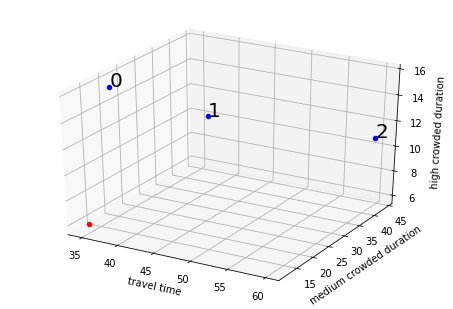

In [10]:
def main():
    g1, g2, g3 = create_graph("Network 1.txt")
    
    origin, destination = get_od_from_user()
    
    tt1, tt2, tt3, cd_max, cd1_max, cd2_max = get_shortest_tt(g1, g2, g3, origin, destination)
    
    print("tt1 = ", tt1, ", tt2 = ", tt2, ", tt3 = ", tt3)
    print("cd_max = ", cd_max, ", cd1_max = ", cd1_max, ", cd2_max = ", cd2_max)

    optimal_paths = find_optimal_paths(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
    
    best_optimal_paths = get_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)
    
    #print(optimal_paths)
    
    if not optimal_paths:
        print("No path exists between", origin, "and", destination, "!")
    else:
        for path in optimal_paths:
            if np.shape(path)[0] == 3:
                print("optimal path, travel time, crowded duration")
                print(path)
                print("********")
            else:
                print("optimal path, travel time, medium crowded duration, high crowded duration")
                print(path)
                print("********")
    if not best_optimal_paths:
        print("Pareto optimal solutions are not necessary", origin, "and", destination, "!")
    else:
        for path in best_optimal_paths:
            if np.shape(path)[0] == 3:
                print("best optimal path, travel time, crowded duration")
                print(path)
                print("********")
            else:
                print("best optimal path, travel time, medium crowded duration, high crowded duration")
                print(path)
                print("********")
                
    plot_pareto_best(g1, g2, g3, origin, destination, tt1, tt2, tt3, cd_max, cd1_max, cd2_max)

if __name__ == "__main__":
    main()